In [1]:
from fastai.vision.all import *

from PIL import Image
import numpy as np
import pandas as pd
import os
from pathlib import Path

np.random.seed(0)

In [2]:
path = Path('../2.4_Modify_Entire_Dataset/CheXpert-v1.0-small-MOD/')

In [3]:
df_mod = pd.read_csv('df_mod_pathadjusted.csv', index_col = 0)

In [4]:
df_mod.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,magnets,no_mod,bullet,coin
0,train/patient00001/study1/view1_frontal_mod_magnets.jpg,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,1.0,True,NaN,NaN,NaN
1,train/patient00002/study2/view1_frontal_mod_no_mod.jpg,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,NaN,-1.0,NaN,1.0,NaN,NaN,True,NaN,NaN
2,train/patient00002/study1/view1_frontal_mod_no_mod.jpg,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,True,NaN,NaN
3,train/patient00002/study1/view2_lateral_mod_no_mod.jpg,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,True,NaN,NaN
4,train/patient00003/study1/view1_frontal_mod_bullet.jpg,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN


In [ ]:
files = get_image_files(path)
len(files)

In [ ]:
files[0]

In [27]:
def label_func(f): return '_no_mod' not in f

In [28]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

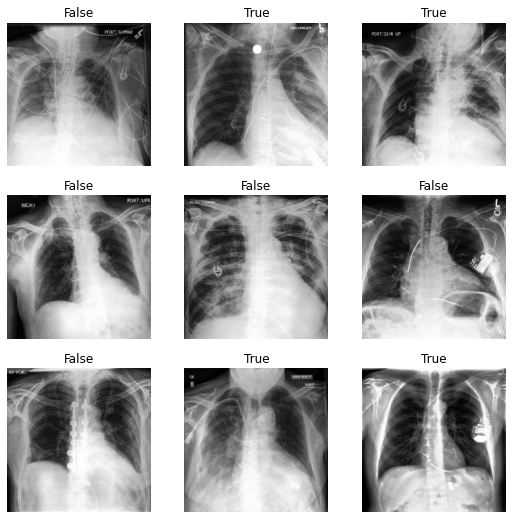

In [36]:
dls.show_batch()

In [50]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(valley=0.005248074419796467)

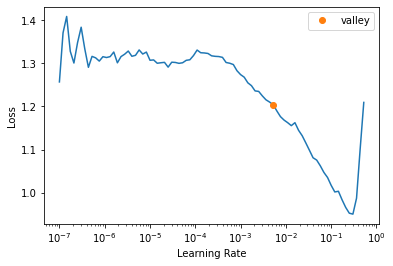

In [51]:
learn.lr_find()

In [52]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.094063,0.073990,0.975693,16:40:11


KeyboardInterrupt: 

In [53]:
tta = learn.tta(use_max=True)

KeyboardInterrupt: 

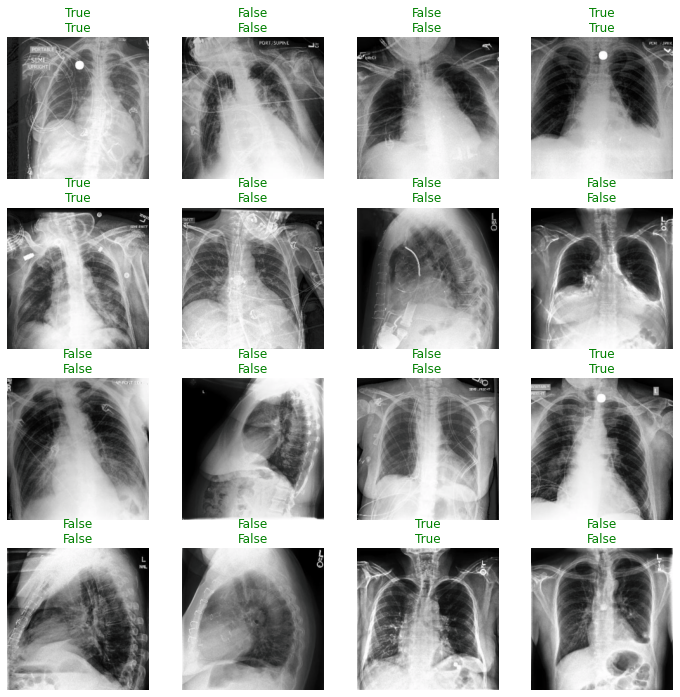

In [54]:
learn.show_results(max_n=16)

In [55]:
interp = Interpretation.from_learner(learn)

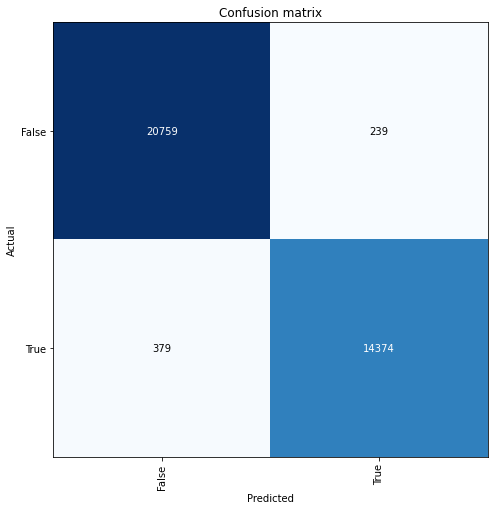

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [57]:
learn.save('20220422_model_binary_mod_nomod')

Path('../2.4_Modify_Entire_Dataset/CheXpert-v1.0-small-MOD/models/20220422_model_binary_mod_nomod.pth')

In [58]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

20759 239 379 14374


In [59]:
sensitivity = tp/(tp + fn)
sensitivity

0.9743103097675049

**Specificity = True Negative/(False Positive + True Negative)**

In [60]:
specificity = tn/(fp + tn)
specificity

0.9886179636155824

The model has a specificity of 94% and hence can correctly detect 94% of the time that a patient does **not** have a coin in the trachea but will incorrectly classify that 6% of the patients have coin in the trachea (False Postive) but actually do not.

This is also known as a **Type I error**

**Positive Predictive Value (PPV)**

In [61]:
ppv = tp/(tp+fp)
ppv

0.9836446999247246

In this case the model performs well in correctly predicting patients with coin in the trachea.

**Negative Predictive Value (NPV)**

In [62]:
npv = tn/(tn+fn)
npv

0.9820702053174378